In [461]:
import pandas as pd
import io
import requests
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
%load_ext rpy2.ipython

pd.options.display.max_columns = 50

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [462]:
fp = '../../../Downloads/pacifica.csv'

In [463]:
df = pd.read_csv(fp)

In [464]:
df.shape

(381202, 25)

In [465]:
df.head(2)

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,283996800,1979-01-01 00:00:00 +0000 UTC,-28800,Pacifica,37.613825,-122.486919,9.82,5.55,7.57,10.60,1024,NaN,NaN,30,2.1,60,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
1,284000400,1979-01-01 01:00:00 +0000 UTC,-28800,Pacifica,37.613825,-122.486919,10.42,6.20,9.62,10.61,1024,NaN,NaN,30,2.1,60,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d


In [466]:
# pd.date_range(start=df['dt_iso'].min(), end=df['dt_iso'].max(), freq='h').shape

## check for duplicates

In [467]:
df['dt'].duplicated().sum() / df.shape[0]

0.03836810929638355

So there are duplicates

In [468]:
first_duplicated_val =df.loc[df['dt'].duplicated(), 'dt'].values[0]

df.loc[df['dt']==first_duplicated_val, :]

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
32,284112000,1979-01-02 08:00:00 +0000 UTC,-28800,Pacifica,37.613825,-122.486919,5.97,0.9,3.09,9.64,1028,NaN,NaN,70,4.6,80,NaN,NaN,NaN,NaN,40,711,Smoke,smoke,50n
33,284112000,1979-01-02 08:00:00 +0000 UTC,-28800,Pacifica,37.613825,-122.486919,5.97,0.9,3.09,9.64,1028,NaN,NaN,70,4.6,80,NaN,NaN,NaN,NaN,40,721,Haze,haze,50n


So it appears that we can have multiple records per timestamp. And it looks like the numerical data is the same, but the `weather_main` column (and associated columns) might be different among duplicated rows.

The quickest solution is to just drop the duplicated rows - let's start with that. 

In [469]:
df = df.drop_duplicates(subset='dt', keep='first')

## datetime formatting

In [470]:
df['dt'] = pd.to_datetime(df['dt_iso'].apply(lambda x: x.split(' +')[0]), infer_datetime_format=True, utc=True)

df['day'] = df['dt'].dt.day # not entirely correct as we need to first convert from UTC to local time

df['year'] = df['dt'].dt.year

df['year_month_str'] = df['dt'].dt.strftime('%Y-%m')

df['date'] = df['dt'].dt.date

df['year_str'] = df['year'].astype(str)

df['year'].unique().shape

(42,)

In [471]:
# pd.date_range(start=df['dt'].min(), end=df['dt'].max(), freq='h').shape[0]

## look at the data recovery %

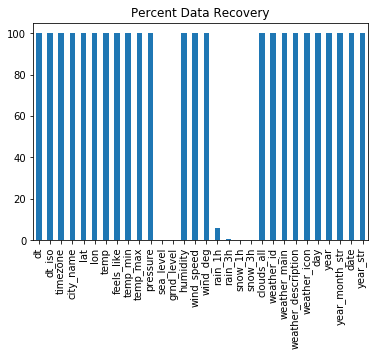

In [472]:
(100 - df.isna().sum() / len(df) * 100).plot.bar()
plt.title('Percent Data Recovery');

## Look at the data recovery, by year

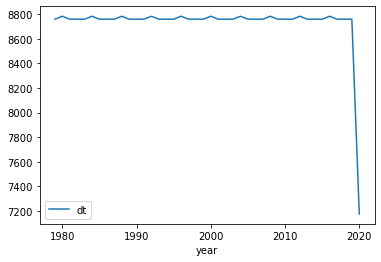

In [473]:
count = df[['year','dt']].groupby('year').count()
count.plot();

## incorporate dummies from `weather_main`

In [474]:
# df['weather_main'].value_counts()

In [475]:
# merge with main dataframe
df = df.merge(pd.get_dummies(df['weather_main']), how='left', left_index=True, right_index=True)

## look at an area plot of the weather type variable `weather_main`

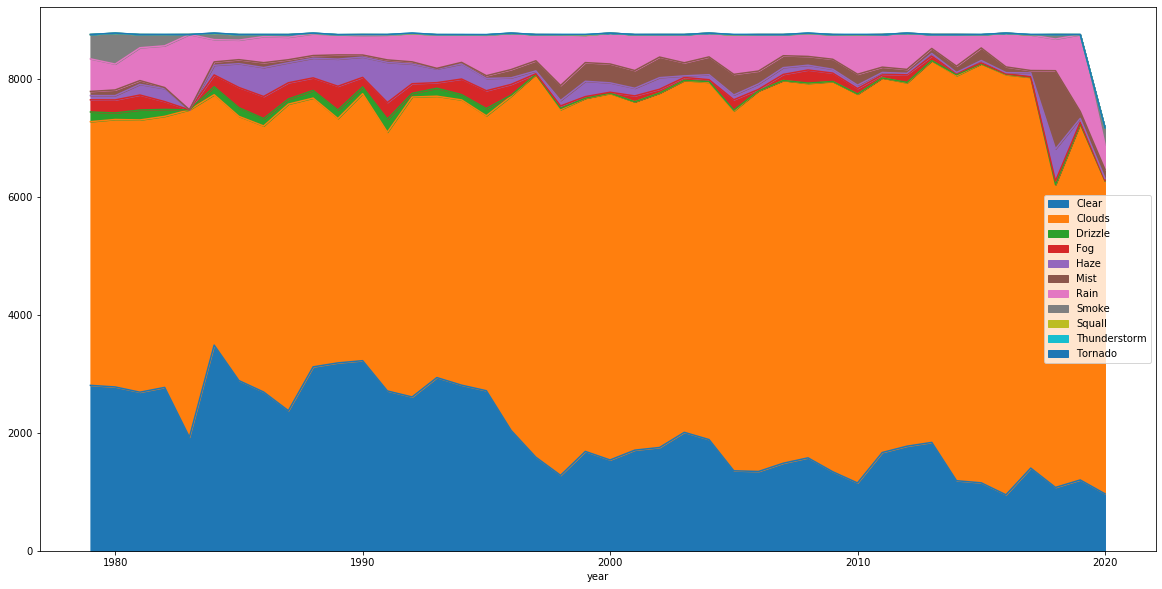

In [476]:
weather_main_cols = ['Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Smoke', 'Squall', 'Thunderstorm', 'Tornado']
df[['year'] + weather_main_cols].groupby('year').sum().plot.area(figsize=(20,10));

It looks like clear intervals (blue) are decreasing over time, and it's actually getting cloudier (orange).

It also looks like there's some kind of state change around the middle of the 1990s... not sure what that is about but there's a big drop in the # of clear days after that point. 

This plot incorporates each hour of the day - whereas I'm only interested in day-time intervals, so let's filter for those. 

## incorporate sun position

Let's also add sun position so we can filter for day-time intervals. 

In [477]:
import pvlib

In [478]:
from pvlib.solarposition import get_solarposition

In [479]:
sp = get_solarposition(df['dt'], latitude=df['lat'].unique()[0], longitude=df['lon'].unique()[0])

In [480]:
df = df.merge(right=sp, how='left', left_on='dt', right_index=True)

## create filtered dataframe

### Filter for intervals where the sun is over the horizon

In [481]:
dff = df[df['apparent_elevation'] > 0].copy()

In [482]:
dff.shape

(185541, 49)

## area plot without night-time intervals

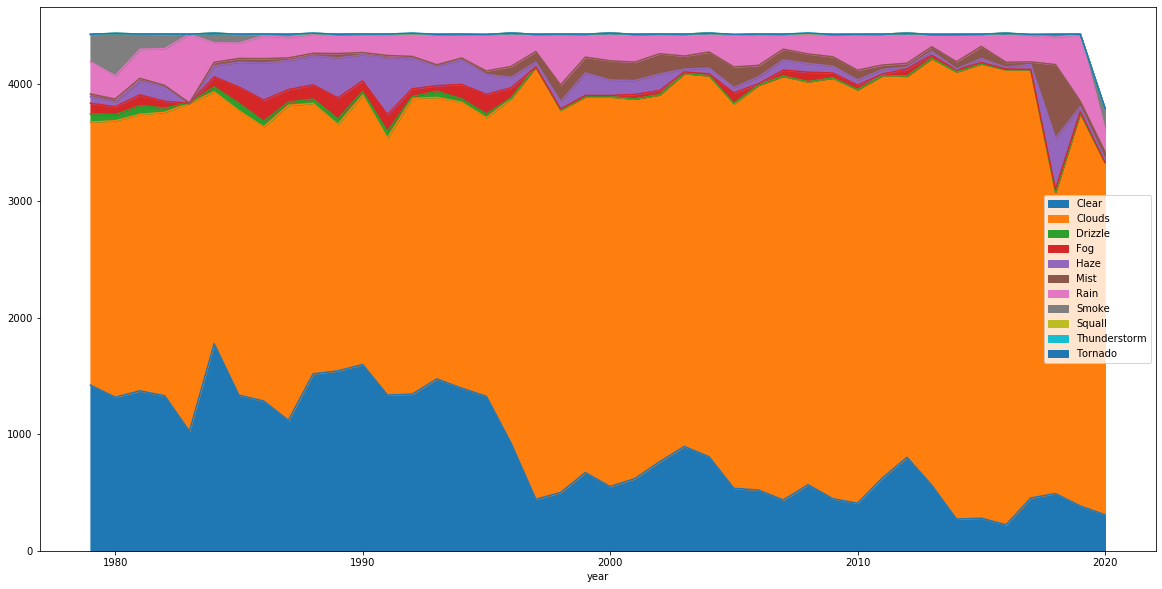

In [483]:
weather_main_cols = [
    'Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Smoke', 'Squall', 'Thunderstorm', 'Tornado'
]

dff[['year'] + weather_main_cols].groupby('year').sum().plot.area(figsize=(20,10));


We're still seeing the same trend and disconinuity.

## Let's look at a ridge plot of the `clouds_all` columns

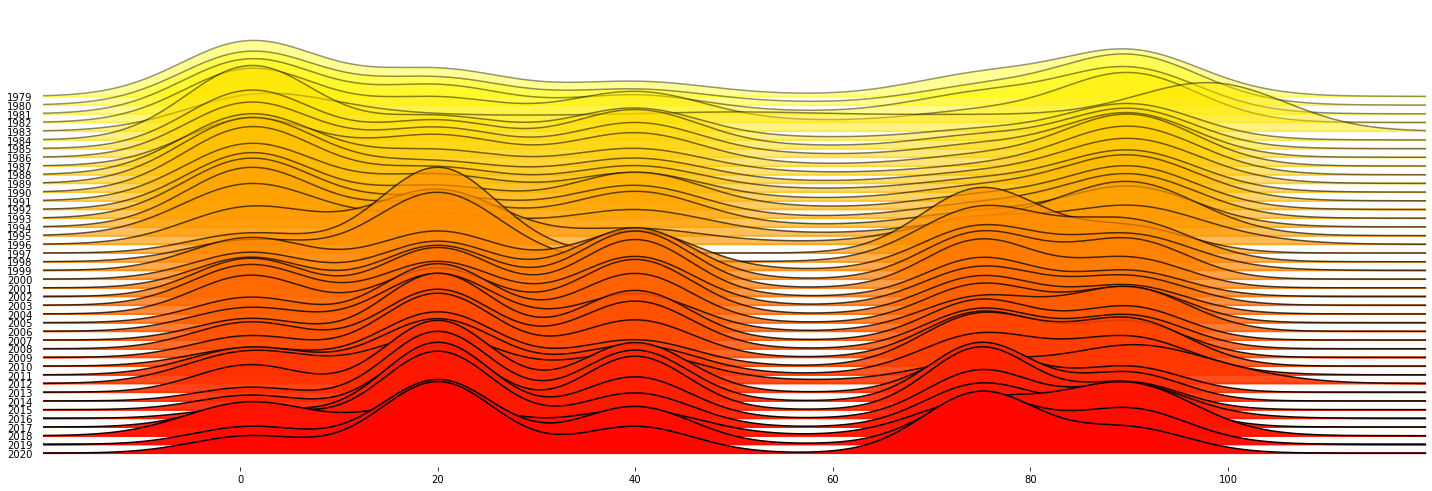

In [484]:
import joypy
from matplotlib import cm
joypy.joyplot(data=dff, column='clouds_all', by='year_str', 
              fade=True, 
              figsize=(20,7), 
              colormap=cm.autumn_r, 
              ylim='max', 
              overlap=2);

Let's look at the distribution of `clouds_all` for each year

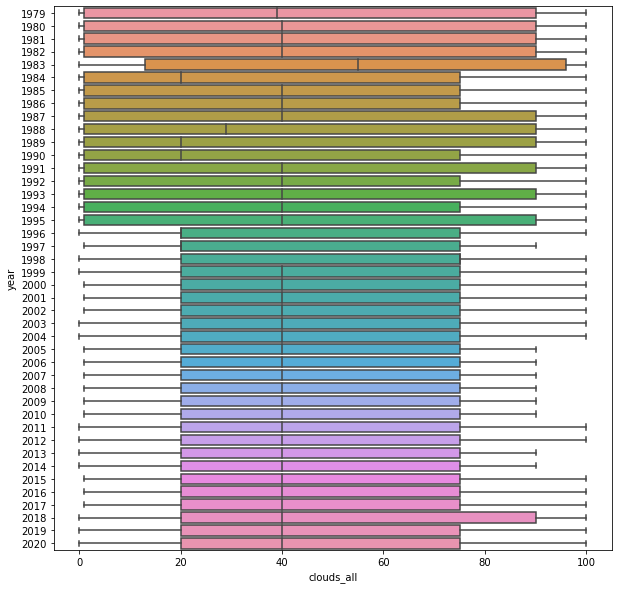

In [485]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.boxplot(data=dff, orient='h', y='year', x='clouds_all');

OK so based on that it's not looking like the distribution of `clouds_all` really changes except for from 1995 to 1996, where the distribution seems to tighten substantially. My guess is something changed in the measurements were taken, but let's explore further.  

In [486]:
dff = dff[dff['year']>1995]

Let's aggregate to the yearly level.

In [489]:
agg = dff[['year','clouds_all']].groupby('year').agg(['mean','min','max','count'])
agg.columns = agg.columns.droplevel(0)

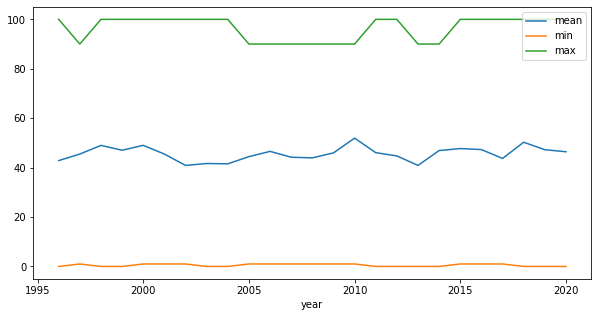

In [491]:
agg[['mean','min','max']].plot(figsize=(10,5));

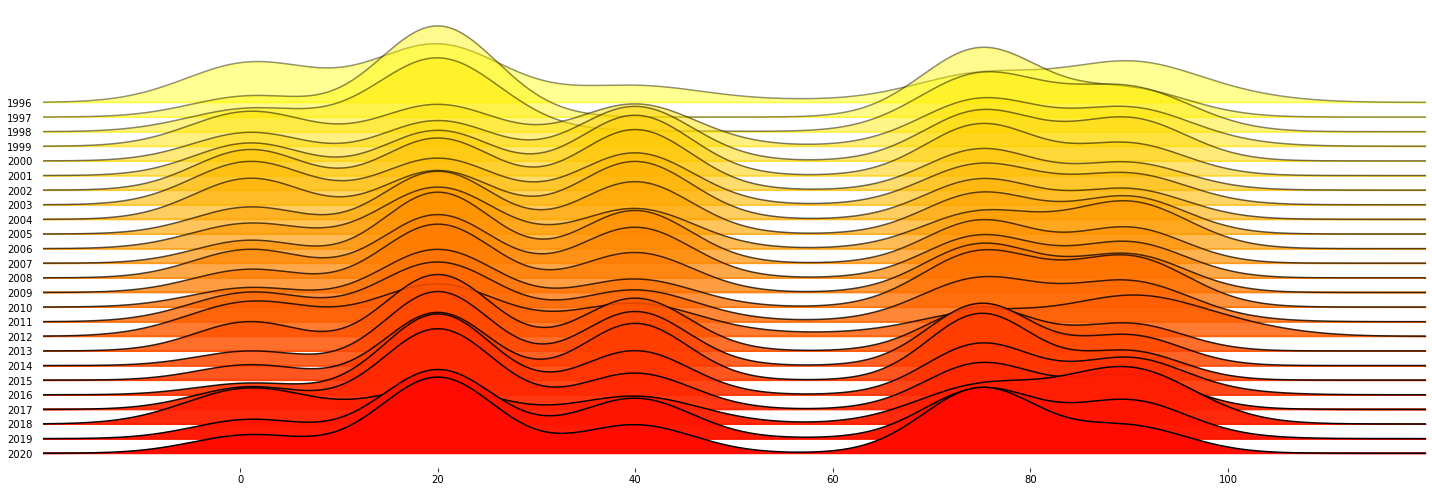

In [492]:
import joypy
from matplotlib import cm
joypy.joyplot(data=dff, column='clouds_all', by='year_str', 
              fade=True, 
              figsize=(20,7), 
              colormap=cm.autumn_r, 
              ylim='max', 
              overlap=2);

So it's not really looking like the `clouds_all` distribution is changing much from year to year. Is there a way we can make into a quantitative declaration?

I want to know, has the number of 'clear' days increased over the years? 
We have to define what a 'clear' day is first.

In [493]:
# first aggregate to days

In [494]:
days = dff[['Clear','date']].groupby('date').agg(['sum','count'])
days.columns = days.columns.droplevel(0)
days['year_str'] = [str(idx)[:4] for idx in days.index]

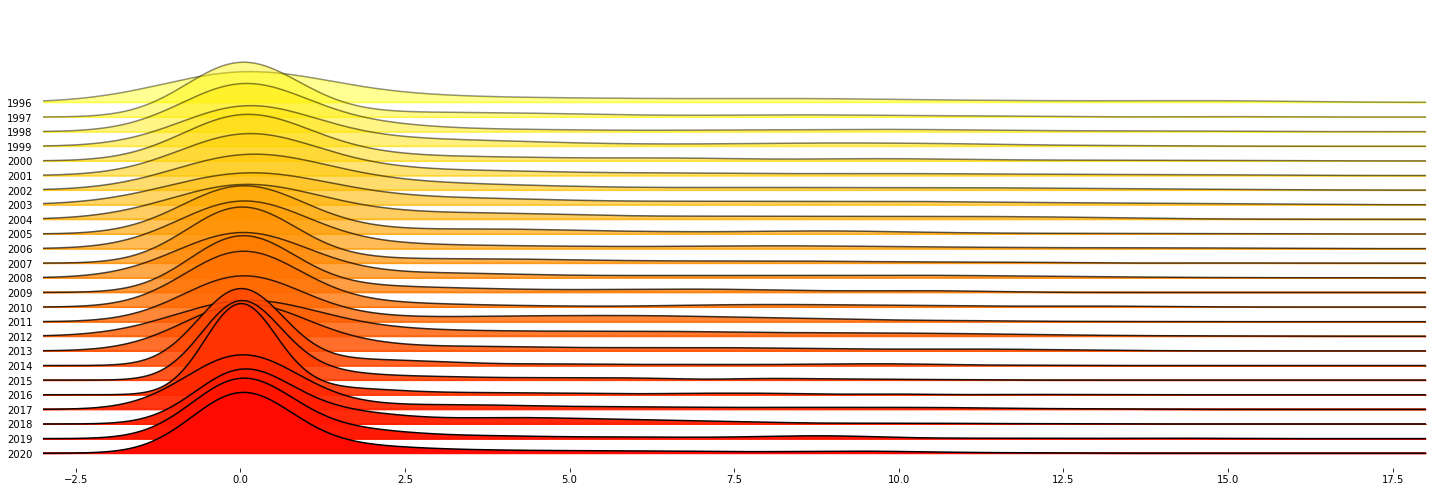

In [495]:
import joypy
from matplotlib import cm
joypy.joyplot(data=days.reset_index(), column='sum', by='year_str', 
              fade=True, 
              figsize=(20,7), 
              colormap=cm.autumn_r, 
              ylim='max', 
              overlap=2);

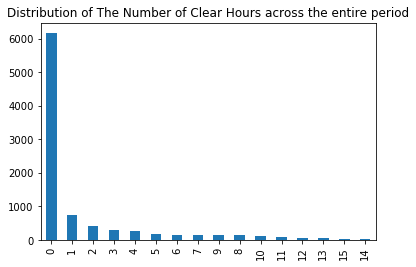

In [496]:
days['sum'].value_counts().plot.bar();
plt.title('Distribution of The Number of Clear Hours across the entire period');

Let's set the threshold at 1...

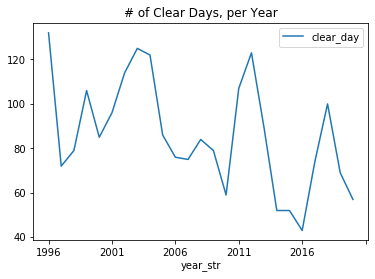

In [509]:
days['clear_day'] = (days['sum'] > 1).astype(int)
days[['year_str','clear_day']].groupby('year_str').sum().plot()
plt.title('# of Clear Days, per Year');

If anything it looks like a downward trend, implying it's getting less clear.